In [6]:
from attention_keras.src.layers.attention import AttentionLayer

In [5]:
!unrar x '/content/attention_keras-master.rar'


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/attention_keras-master.rar

Creating    attention_keras-master                                    OK
Creating    attention_keras-master/src                                OK
Creating    attention_keras-master/src/layers                         OK
Extracting  attention_keras-master/src/layers/attention.py                79%  OK 
Extracting  attention_keras-master/src/layers/__init__.py                 84%  OK 
All OK


In [7]:
import numpy as np  
import pandas as pd 
import re           
from bs4 import BeautifulSoup 
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords   
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import files
files.upload()

Saving Reviews.csv to Reviews.csv


In [8]:
data=pd.read_csv("/content/Reviews.csv")

In [9]:
data.drop_duplicates(subset=['Text'],inplace=True)  
data.dropna(axis=0,inplace=True) 

In [10]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}

In [11]:
data['Text'][:10]

0    I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...
1             Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".
2    This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with ...
3    If you are looking for the secret ingredient in Robitussin I believe I have found it.  I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda.  The fl...
4                                                               Great taffy at a great price.  There was a wide assortment of yummy taffy.  Delivery was very quick.  If your a taff

In [14]:
stop_words = set(stopwords.words('english')) 
def text_cleaner(text):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    tokens = [w for w in newString.split() if not w in stop_words]
    long_words=[]
    for i in tokens:
        if len(i)>=3:                  #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

cleaned_text = []
for t in data['Text']:
    cleaned_text.append(text_cleaner(t))

In [15]:
data['Summary'][:10]

0                            Good Quality Dog Food
1                                Not as Advertised
2                            "Delight" says it all
3                                   Cough Medicine
4                                      Great taffy
5                                       Nice Taffy
6    Great!  Just as good as the expensive brands!
7                           Wonderful, tasty taffy
8                                       Yay Barley
9                                 Healthy Dog Food
Name: Summary, dtype: object

In [16]:
def summary_cleaner(text):
    newString = re.sub('"','', text)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    newString = newString.lower()
    tokens=newString.split()
    newString=''
    for i in tokens:
        if len(i)>1:                                 
            newString=newString+i+' '  
    return newString


cleaned_summary = []
for t in data['Summary']:
    cleaned_summary.append(summary_cleaner(t))

data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary
data['cleaned_summary'].replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

In [17]:
for i in range(5):
    print("Review:",data['cleaned_text'][i])
    print("Summary:",data['cleaned_summary'][i])
    print("\n")

Review: bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better
Summary: good quality dog food 


Review: product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo
Summary: not as advertised 


Review: confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch
Summary: delight says it all 


Review: looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal
Summary: cough medicine 


Review: great taffy great price wide assortment yummy taffy delivery quick taffy lover deal
Summary: great taffy 




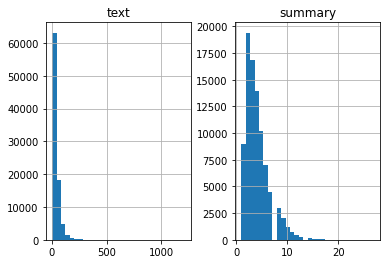

In [18]:
import matplotlib.pyplot as plt
text_word_count = []
summary_word_count = []


for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})
length_df.hist(bins = 30)
plt.show()

In [19]:

max_len_text=55
max_len_summary=15

In [20]:
cleaned_text = np.array(data['cleaned_text'])
cleaned_summary = np.array(data['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    
    if(len(cleaned_summary[i].split())<=max_len_summary and len(cleaned_text[i].split())<=max_len_text):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])

df=pd.DataFrame({'text':short_text,'summary':short_summary})


In [21]:
df['summary'] = df['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

In [22]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(df['text'],df['summary'],test_size=0.2,random_state=0,shuffle=True) 


In [23]:
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))

thresh=4
cnt=0
tot_cnt=0
freq=0
tot_freq=0


for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)


x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))



x_tr_seq  =  x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq =  x_tokenizer.texts_to_sequences(x_val)



x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_len_text, padding='post') 
x_val   =   pad_sequences(x_val_seq, maxlen=max_len_text, padding='post')



x_voc   =  x_tokenizer.num_words + 1


print(x_voc)


% of rare words in vocabulary: 65.05646355270416
Total Coverage of rare words: 2.1024270167912915
12038


In [24]:
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))


thresh=6
cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)


y_tokenizer = Tokenizer(num_words=tot_cnt-cnt)
y_tokenizer.fit_on_texts(list(y_tr))



y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq    =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq , maxlen=max_len_summary, padding='post')
y_val   =   pad_sequences(y_val_seq , maxlen=max_len_summary, padding='post')

y_voc  =   y_tokenizer.num_words +1

y_tokenizer.word_counts['sostok'], len(y_tr)

% of rare words in vocabulary: 76.67045156782251
Total Coverage of rare words: 4.525089060999185


(57657, 57657)

In [25]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

In [26]:
from keras import backend as K 
K.clear_session() 
latent_dim = 200
embedding_dim=110 

# Encoder 
encoder_inputs = Input(shape=(max_len_text,)) 
enc_emb = Embedding(x_voc, latent_dim,trainable=True)(encoder_inputs) 

#LSTM 1 
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb) 

#LSTM 2 
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1) 

#LSTM 3 
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True) 
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2) 

# Set up the decoder. 
decoder_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(y_voc, latent_dim,trainable=True) 
dec_emb = dec_emb_layer(decoder_inputs) 

#LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c]) 

#Attention Layer
attn_layer = AttentionLayer(name='attention_layer') 
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs]) 

# Concat attention output and decoder LSTM output 
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#Dense layer
decoder_dense = TimeDistributed(Dense(y_voc, activation='softmax')) 
decoder_outputs = decoder_dense(decoder_concat_input) 

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 55)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 55, 200)      2407600     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 55, 200), (N 320800      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [27]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

In [28]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=50,batch_size=128, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Epoch 1/50
442/442 [==============================] - 1024s 2s/step - loss: 1.9886 - val_loss: 1.4862
Epoch 2/50
442/442 [==============================] - 1020s 2s/step - loss: 1.4709 - val_loss: 1.3781
Epoch 3/50
442/442 [==============================] - 1031s 2s/step - loss: 1.3710 - val_loss: 1.3170
Epoch 4/50
 60/442 [===>..........................] - ETA: 13:42 - loss: 1.2989

KeyboardInterrupt: ignored

In [29]:
y_tr.shape ,x_tr.shape

((56562, 15), (56562, 55))

In [31]:

reverse_target_word_index=y_tokenizer.index_word 
reverse_source_word_index=x_tokenizer.index_word 
target_word_index=y_tokenizer.word_index

In [ ]:
#####Inference

In [32]:
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# decoder inference
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_len_text,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Final decoder model
decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])

In [33]:
def decode_sequence(input_seq):
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = target_word_index['sostok']
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if (sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

            
        if (sampled_token == 'eostok' or len(decoded_sentence.split()) >= (max_len_summary-1)):
                stop_condition = True

        
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

       
        e_h, e_c = h, c

    return decoded_sentence

In [34]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
      if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
        newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
      if(i!=0):
        newString=newString+reverse_source_word_index[i]+' '
    return newString

In [35]:

for i in range(1,80):
  print("Review:",seq2text(x_tr[i]))
  print("Original summary:",seq2summary(y_tr[i]))
  print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_len_text)))
  print("\n")

Review: packing poor mix spilled packing box could get enough make pancakes good 
Original summary: red pancake mix 
Predicted summary:  not what expected


Review: served friend cannot stop least day need add sweetners caffeine great complex flavor 
Original summary: love this tea 
Predicted summary:  best popcorn ever


Review: item still cheaper costco sorry amazon think bit top 
Original summary: good price 
Predicted summary:  not what expected


Review: pleasant surprise awaited first ordered grove square milk chocolate hot cocoa cups coffee drinker use keurig cup brewer mostly make cocoa brands tried simply hit mark grove square cocoa tasted full flavored enough chocolate essence make perfect drink first experience made anticipate next time popped grove square cup machine 
Original summary: good taste comes in small packages 
Predicted summary:  best chocolate ever


Review: cat absolutely loves temptation flavors feel like getting oral care add mix get amazon products time fine

In [32]:
reverse_source_word_index

{1: 'like',
 2: 'good',
 3: 'great',
 4: 'taste',
 5: 'product',
 6: 'one',
 7: 'love',
 8: 'flavor',
 9: 'coffee',
 10: 'would',
 11: 'tea',
 12: 'really',
 13: 'get',
 14: 'amazon',
 15: 'price',
 16: 'food',
 17: 'buy',
 18: 'much',
 19: 'best',
 20: 'time',
 21: 'little',
 22: 'use',
 23: 'find',
 24: 'tried',
 25: 'better',
 26: 'also',
 27: 'well',
 28: 'chocolate',
 29: 'make',
 30: 'try',
 31: 'dog',
 32: 'eat',
 33: 'even',
 34: 'bought',
 35: 'found',
 36: 'could',
 37: 'drink',
 38: 'sweet',
 39: 'cup',
 40: 'delicious',
 41: 'order',
 42: 'bag',
 43: 'sugar',
 44: 'used',
 45: 'tastes',
 46: 'recommend',
 47: 'first',
 48: 'favorite',
 49: 'loves',
 50: 'store',
 51: 'cannot',
 52: 'free',
 53: 'made',
 54: 'nice',
 55: 'way',
 56: 'box',
 57: 'think',
 58: 'since',
 59: 'got',
 60: 'water',
 61: 'dogs',
 62: 'two',
 63: 'day',
 64: 'mix',
 65: 'perfect',
 66: 'give',
 67: 'bit',
 68: 'still',
 69: 'ordered',
 70: 'easy',
 71: 'snack',
 72: 'flavors',
 73: 'many',
 74: 'nev